# TFM - COMPARISON OF UNIT BIDS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta

from TFM_PredCurve_Tools import data_date_hour_info, convert_to_df_curve, days_25h_23h
from TFM_PredCurve_Tools import data_report, data_report_total, missing_dates, bid_hour_summary
from TFM_PredCurve_Tools import plot_bid_curve, plot_marginal_price, plot_bid_margprice, plot_bid_margprice_day
from TFM_PredCurve_Tools import plot_bid_curve_day, plot_marginal_price_day, myplot, plot_24bids
from TFM_PredCurve_Tools import plot_bid_timeperiod, plot_bid_timeperiod_line
from TFM_PredCurve_Tools import plot_energy_timeperiod, plot_energy_timeperiod_line

In [2]:
#pd.reset_option('precision')
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

In [3]:
#unit_path = '/home/dsc/Documents/TFM/Data/OMIE/'
unit_path = './Data_Input/'
unit_output_path = './Data_Output/'

In this notebook, different combined cycles and hydraulic unit bids are plotted in order to compare them, and to show the methodology they used during the electricity energy-priece auction.

### CREATING UNIT BID DATAFRAMES

First of all, two dataframes are created with the bid information of several units selected in the lists below.

In [4]:
#More units can be included as far the corresponding data file is in the Data_Input folder

unit_list = ['PALOS1',
             'PALOS2',
             'PALOS3',
             'SAGUNTO1',
             'SAGUNTO2',
             'ARCOS1',
             'ARCOS2',
             'ARCOS3',
             'COLON4',
             'ESCATRON3',
             'ALGECIRAS3',
             'CASTELNOU']

In [5]:
#More units can be included as far the corresponding data file is in the Data_Input folder

unit_hyd_list = ['AGUAYO_GEN',
                 'TAJOENCANT',
                 'MORALETS',
                 'MUELA',
                 'SIL']

In order to create create a new dataframe with only the units selected above, the following code must be runned. In this example, as the ".csv" files have been created, **the code is shown as markdown**.

####Convert this cell to code to create new dataframes if needed

####List of dataframes for COMBINED CYCLE units

df_unit_list = []
for unit in unit_list:
    df_unit = pd.read_csv(unit_path + 'OMIE_' + unit + '_112019_102020.csv',index_col=0)
    df_unit = convert_to_df_curve(df_unit)
    df_unit['Unit'] = unit
    df_unit_list.append(df_unit)

####Creating a single dataframe with all COMBINED CYCLE units selected

df_units = pd.concat(df_unit_list)

####Storing info locally

df_units.to_csv(unit_path + 'UNITS_CC_112019_102020.csv')

####Dataframe for HYDRAULIC units

df_unit_hyd_list = []
for unit in unit_hyd_list:
    df_unit = pd.read_csv(unit_path + 'OMIE_' + unit + '_112019_102020.csv',index_col=0)
    df_unit = convert_to_df_curve(df_unit)
    df_unit['Unit'] = unit
    df_unit_hyd_list.append(df_unit)

####Creating a single dataframe with all HYDRAULIC units selected

df_units_hyd = pd.concat(df_unit_hyd_list)

####Storing info locally

df_units_hyd.to_csv(unit_path + 'UNITS_HYD_112019_102020.csv')

In [6]:
#Reading the info from the local COMBINED CYCLE UNITS csv file, created and stored in the cell above
df_units = pd.read_csv(unit_path + 'UNITS_CC_112019_102020.csv',index_col=0)

In [7]:
df_units.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Unit
0,394.10,2019,11,1,1,12,180.30,394.10,2019-11-01,Friday,394.10,PALOS1
1,394.10,2019,11,1,2,12,180.30,394.10,2019-11-01,Friday,394.10,PALOS1
2,394.10,2019,11,1,3,1,1.13,50.00,2019-11-01,Friday,50.00,PALOS1
3,394.10,2019,11,1,3,12,180.30,344.10,2019-11-01,Friday,394.10,PALOS1
4,394.10,2019,11,1,4,1,1.13,60.00,2019-11-01,Friday,60.00,PALOS1


In [8]:
df_units.shape

(508579, 12)

In [9]:
df_units.dtypes

Pot_max       float64
Year            int64
Month           int64
Day             int64
Period          int64
Block           int64
Price         float64
Energy        float64
Date           object
Weekday        object
Energy_tot    float64
Unit           object
dtype: object

In [10]:
#'Date' type must be modified
df_units['Date'] = df_units['Date'].astype('datetime64[ns]')

In [11]:
#Reading the info from the local HYDRALIC UNITS csv file.
df_units_hyd = pd.read_csv(unit_path + 'UNITS_HYD_112019_102020.csv',index_col=0)

In [12]:
df_units_hyd.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Unit
0,360.60,2019,11,1,1,1,42.00,80.00,2019-11-01,Friday,80.00,AGUAYO_GEN
1,360.60,2019,11,1,1,2,45.00,80.00,2019-11-01,Friday,160.00,AGUAYO_GEN
2,360.60,2019,11,1,1,3,50.00,80.00,2019-11-01,Friday,240.00,AGUAYO_GEN
3,360.60,2019,11,1,1,4,55.00,80.00,2019-11-01,Friday,320.00,AGUAYO_GEN
4,360.60,2019,11,1,1,5,180.30,40.60,2019-11-01,Friday,360.60,AGUAYO_GEN


In [13]:
df_units_hyd.shape

(257558, 12)

In [14]:
#'Date' type must be modified
df_units_hyd['Date'] = df_units_hyd['Date'].astype('datetime64[ns]')

### RETRIEVING DATA OF MARGINAL PRICES

In [15]:
df_marg_price = pd.read_csv(unit_path + 'MARGINAL_PRICES_SPAIN.csv',index_col=0)

In [16]:
#Only information of the time period of the unit

df_price = df_marg_price[df_marg_price[(df_marg_price['Date']== str(df_units['Date'].min())[0:10]) &
              (df_marg_price['Period']== df_marg_price['Period'].min())].index[0]:
              df_marg_price[(df_marg_price['Date']== str(df_units['Date'].max())[0:10]) &
              (df_marg_price['Period']== 24)].index[0]+1]

df_price.reset_index(drop=True,inplace=True)

#### COMBINED CYCLE UNITS

In [17]:
df_units = df_units.merge(df_price[['Year', 'Month', 'Day', 'Period','Marg_Price']], how = 'left')

In [18]:
df_units.head()

,Pot_max,Year,Month,Day,Period,Block,Price,Energy,Date,Weekday,Energy_tot,Unit,Marg_Price
0,394.10,2019,11,1,1,12,180.30,394.10,2019-11-01,Friday,394.10,PALOS1,42.10
1,394.10,2019,11,1,2,12,180.30,394.10,2019-11-01,Friday,394.10,PALOS1,40.18
2,394.10,2019,11,1,3,1,1.13,50.00,2019-11-01,Friday,50.00,PALOS1,32.40
3,394.10,2019,11,1,3,12,180.30,344.10,2019-11-01,Friday,394.10,PALOS1,32.40
4,394.10,2019,11,1,4,1,1.13,60.00,2019-11-01,Friday,60.00,PALOS1,30.01


In [19]:
df_units.shape

(508579, 13)

In the following table, the maximum number of blocks per bid for each unit is shown.

In [20]:
unit_block = pd.DataFrame(df_units.groupby('Unit')['Block'].max().sort_values())
unit_block

,Block
Unit,
COLON4,3
ALGECIRAS3,4
ESCATRON3,4
ARCOS1,5
ARCOS2,6
ARCOS3,6
CASTELNOU,9
PALOS1,12
PALOS2,12


In [21]:
unit_owner_dic = {'Unit': ['PALOS1','PALOS2','PALOS3','SAGUNTO1','SAGUNTO2','ARCOS1','ARCOS2','ARCOS3',
            'COLON4','ALGECIRAS3','ESCATRON3','CASTELNOU'], 
        'Owner': ['NATURGY','NATURGY','NATURGY','NATURGY','NATURGY','IBERDROLA','IBERDROLA','IBERDROLA',
            'ENDESA','REPSOL','REPSOL','ELECTRABEL']}

unit_owner = pd.DataFrame.from_dict(unit_owner_dic)
unit_owner

,Unit,Owner
0,PALOS1,NATURGY
1,PALOS2,NATURGY
2,PALOS3,NATURGY
3,SAGUNTO1,NATURGY
4,SAGUNTO2,NATURGY
5,ARCOS1,IBERDROLA
6,ARCOS2,IBERDROLA
7,ARCOS3,IBERDROLA
8,COLON4,ENDESA
9,ALGECIRAS3,REPSOL


In [22]:
unit_block_index = unit_block.reset_index()

unit_owner_block = unit_block_index.merge(unit_owner, how='inner')
unit_owner_block = unit_owner_block[['Unit', 'Owner', 'Block']]
unit_owner_block

,Unit,Owner,Block
0,COLON4,ENDESA,3
1,ALGECIRAS3,REPSOL,4
2,ESCATRON3,REPSOL,4
3,ARCOS1,IBERDROLA,5
4,ARCOS2,IBERDROLA,6
5,ARCOS3,IBERDROLA,6
6,CASTELNOU,ELECTRABEL,9
7,PALOS1,NATURGY,12
8,PALOS2,NATURGY,12
9,PALOS3,NATURGY,12


In the following table, the mean price per bid for each unit is shown.

In [23]:
df_units.groupby('Unit')['Price'].mean().sort_values()

Unit
CASTELNOU    37.38
ALGECIRAS3   46.78
SAGUNTO2     49.56
ESCATRON3    50.75
SAGUNTO1     51.61
PALOS3       52.21
PALOS2       52.47
PALOS1       52.56
ARCOS3       52.93
ARCOS2       59.99
ARCOS1       62.87
COLON4       66.61
Name: Price, dtype: float64

In the following table, the maximum price per bid for each unit is shown.

In [24]:
df_units.groupby('Unit')['Price'].max().sort_values()

Unit
COLON4       150.02
ARCOS1       150.30
ARCOS3       155.70
ARCOS2       159.30
CASTELNOU    180.00
ALGECIRAS3   180.30
ESCATRON3    180.30
PALOS1       180.30
PALOS2       180.30
PALOS3       180.30
SAGUNTO1     180.30
SAGUNTO2     180.30
Name: Price, dtype: float64

In the following table, the mean price per bid for each unit, not considering prices higher that 120 €/MWh is shown. Note that the marginal price always will be lower than 120 €/MWh, so this table is more realistic than the one presented above regarding the way units presents their bids.

In [25]:
df_units[df_units['Price']<120].groupby('Unit')['Price'].mean().sort_values()

Unit
COLON4       12.55
ESCATRON3    27.97
ALGECIRAS3   29.40
SAGUNTO2     31.04
ARCOS3       31.07
SAGUNTO1     33.56
PALOS2       34.76
ARCOS2       34.77
PALOS3       34.85
PALOS1       35.27
ARCOS1       35.45
CASTELNOU    36.12
Name: Price, dtype: float64

In this table, it can be seen how units offer most of the time: for example it is clear that COLON4 (ENDESA) usually offers a very low price to sell energy in the auction. It can be said something similar to ESCATRÓN3 and ALGECIRAS3 (REPSOL): these units offer prices lower than the mean of the others, that means that these units probably sell energy more frequently than the others.

#### HYDRAULIC UNITS

In [26]:
#Only information of the time period of the unit

df_price_hyd = df_marg_price[df_marg_price[(df_marg_price['Date']== str(df_units_hyd['Date'].min())[0:10]) &
              (df_marg_price['Period']== df_marg_price['Period'].min())].index[0]:
              df_marg_price[(df_marg_price['Date']== str(df_units_hyd['Date'].max())[0:10]) &
              (df_marg_price['Period']== 24)].index[0]+1]

df_price.reset_index(drop=True,inplace=True)

In [27]:
df_units_hyd = df_units_hyd.merge(df_price_hyd[['Year', 'Month', 'Day', 'Period','Marg_Price']], how = 'left')

In the following table, the maximum number of blocks per bid for each unit is shown.

In [28]:
df_units_hyd.groupby('Unit')['Block'].max().sort_values()

Unit
MORALETS       3
TAJOENCANT     4
AGUAYO_GEN     5
SIL           11
MUELA         15
Name: Block, dtype: int64

In the following table, the mean price per bid for each unit is shown.

In [29]:
df_units_hyd.groupby('Unit')['Price'].mean().sort_values()

Unit
MORALETS     40.64
TAJOENCANT   41.18
MUELA        52.63
SIL          62.88
AGUAYO_GEN   67.44
Name: Price, dtype: float64

In the following table, the maximum price per bid for each unit is shown.

In [30]:
df_units_hyd.groupby('Unit')['Price'].max().sort_values()

Unit
MORALETS      68.84
TAJOENCANT    69.20
MUELA        160.00
SIL          160.00
AGUAYO_GEN   180.30
Name: Price, dtype: float64

In the following table, the mean price per bid for each unit, not considering prices higher that 120 €/MWh is shown. Note that the marginal price always will be lower than 120 €/MWh, so this table is more realistic than the one presented above regarding the way units presents their bids.

In [31]:
df_units_hyd[df_units_hyd['Price']<120].groupby('Unit')['Price'].mean().sort_values()

Unit
MORALETS     40.64
TAJOENCANT   41.18
AGUAYO_GEN   43.83
MUELA        44.26
SIL          48.86
Name: Price, dtype: float64

In this table, it can be seen how units offer most of the time: for example it is clear that SIL (ENDESA) usually offers at higher price.

#### STORING DATAFRAMES LOCALLY

### PLOTTING BIDS

In [32]:
sns.set_theme(style='darkgrid')

#### COMBINED CYCLES

Just several bid curves to see the differences in bids for certain dates and hours.

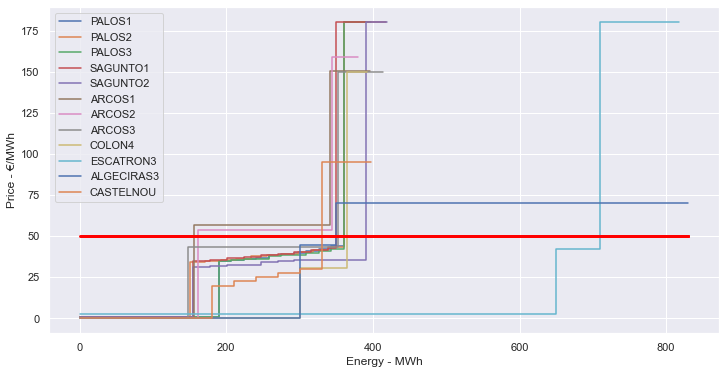

In [33]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-9-15'
hour = 18

for unit in unit_list:
    plot_bid_curve(df_units[df_units['Unit']==unit], date, hour)
    plt.legend(df_units['Unit'].unique())

df_plot = df_units[(df_units['Date'] == date) & (df_units['Period'] == hour)]
plt.plot(pd.Series(0).append(df_plot['Pot_max']), 
                    pd.Series(df_plot['Marg_Price'].iloc[0]).append(df_plot['Marg_Price']), 
                    drawstyle = 'steps', 
                    label = 'steps (=steps-pre)',
                    lw = 3,
                    color = 'red');

In the plot above, it can be seen the differences in the bid curves between units. It is also remarkable that PALOS1, PALOS2, PALOS3, SAGUNTO1 and SAGUNTO2 bids (all Naturgy units) are more complex than the rest of bids.

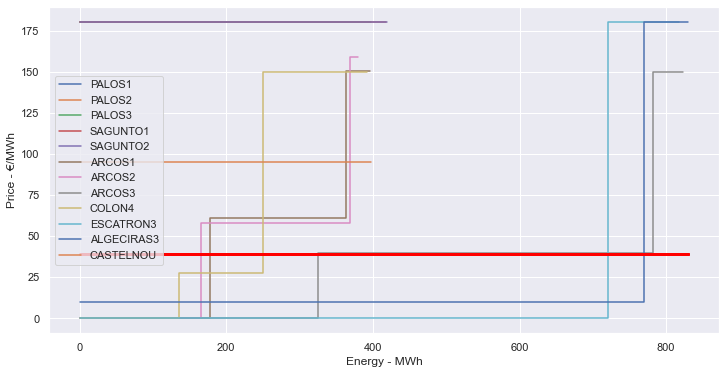

In [34]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-8-15'
hour = 1

for unit in unit_list:
    plot_bid_curve(df_units[df_units['Unit']==unit], date, hour)
    plt.legend(df_units['Unit'].unique())

df_plot = df_units[(df_units['Date'] == date) & (df_units['Period'] == hour)]
plt.plot(pd.Series(0).append(df_plot['Pot_max']), 
                    pd.Series(df_plot['Marg_Price'].iloc[0]).append(df_plot['Marg_Price']), 
                    drawstyle = 'steps', 
                    label = 'steps (=steps-pre)',
                    lw = 3,
                    color = 'red');

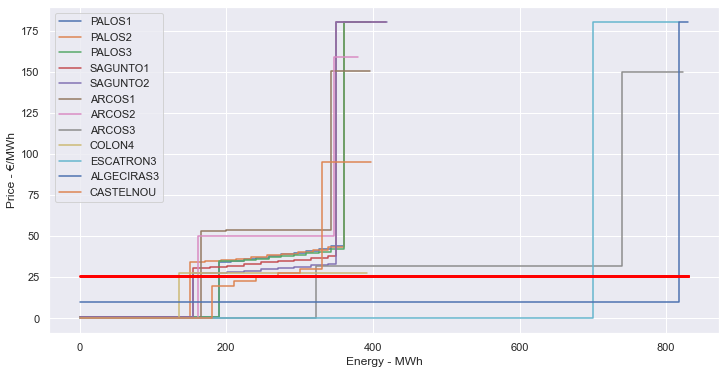

In [35]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-8-15'
hour = 16

for unit in unit_list:
    plot_bid_curve(df_units[df_units['Unit']==unit], date, hour)
    plt.legend(df_units['Unit'].unique())

df_plot = df_units[(df_units['Date'] == date) & (df_units['Period'] == hour)]
plt.plot(pd.Series(0).append(df_plot['Pot_max']), 
                    pd.Series(df_plot['Marg_Price'].iloc[0]).append(df_plot['Marg_Price']), 
                    drawstyle = 'steps', 
                    label = 'steps (=steps-pre)',
                    lw = 3,
                    color = 'red');

#### CREATING A DATAFRAME WITH ALL THE BLOCKS OF ALL THE UNITS SORTED BY ASCENDING PRICE

In this section, the auction methodology of sorting the bids by block price is presented as an example of how the marginal price is defined.

In [36]:
#Choosing a date and an hour
date = '2020-8-15'
hour = 18

df_plot_all = df_units[(df_units['Date']==date) & (df_units['Period']==hour)]

df_plot_all = df_plot_all.sort_values('Price')
df_plot_all.reset_index(drop=True, inplace=True)

#Creating the variable cumulative sum of block energy to plot the curve
df_plot_all['Energy_tot'] = df_plot_all['Energy'].cumsum()

Plotting the bids for all the units considered, sorted by price, together with  the marginal price.

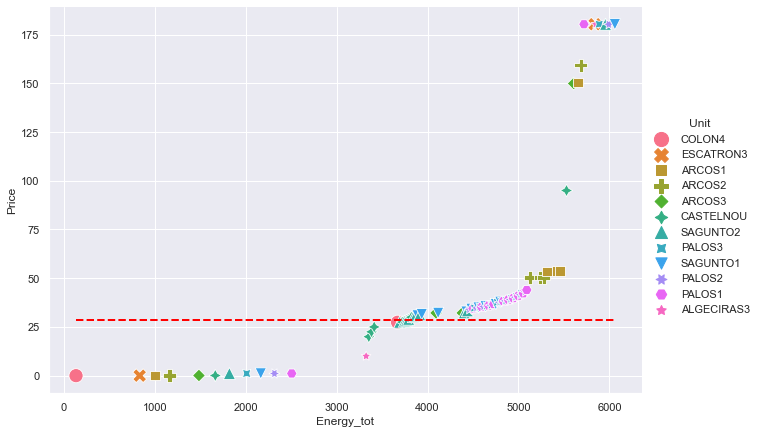

In [37]:
sns.relplot(data=df_plot_all, x='Energy_tot', y='Price', hue='Unit', height=6, aspect=1.5,
           style='Unit', size='Unit', sizes=(100, 200))

plt.plot(df_plot_all['Energy_tot'], df_plot_all['Marg_Price'], ls = '--', lw = 2, color = 'red');

In this plot, all the prices for all the block bids are sorted by ascending order.


In the following plot, bid prices for each unit are plotted in a line.

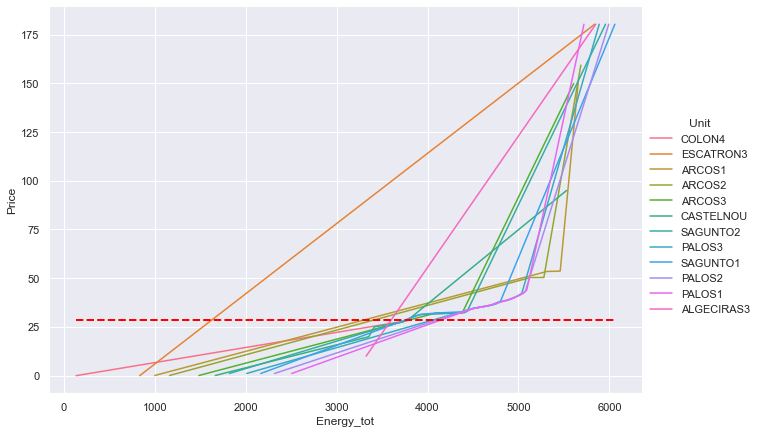

In [38]:
sns.relplot(data=df_plot_all, x='Energy_tot', y='Price', hue='Unit', kind = 'line', height=6, aspect=1.5)

plt.plot(df_plot_all['Energy_tot'], df_plot_all['Marg_Price'], ls = '--', lw = 2, color = 'red');

In this example, it can be seen that most of the units offered energy at higher price that the final one, so most of them could sell less electricity than the maximum the units can provide.

In the following example, a zoom plot of the bid prices that are closed to the marginal price.

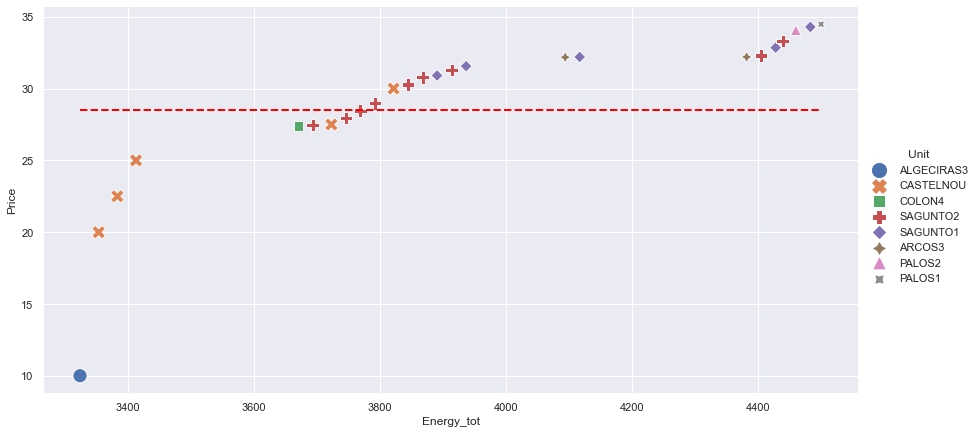

In [39]:
#Choosing the energy range considered
lim_min = 2700
lim_max = 4500

df_plot_all_sub = df_plot_all[(df_plot_all['Energy_tot'] > lim_min) &
                              (df_plot_all['Energy_tot'] < lim_max)]

sns.relplot(data=df_plot_all_sub, x='Energy_tot', y='Price', hue='Unit', height=6, aspect=2,
           style='Unit', size='Unit', sizes=(100, 200))

plt.plot(df_plot_all_sub['Energy_tot'], df_plot_all_sub['Marg_Price'], ls = '--', lw = 2, color = 'red');

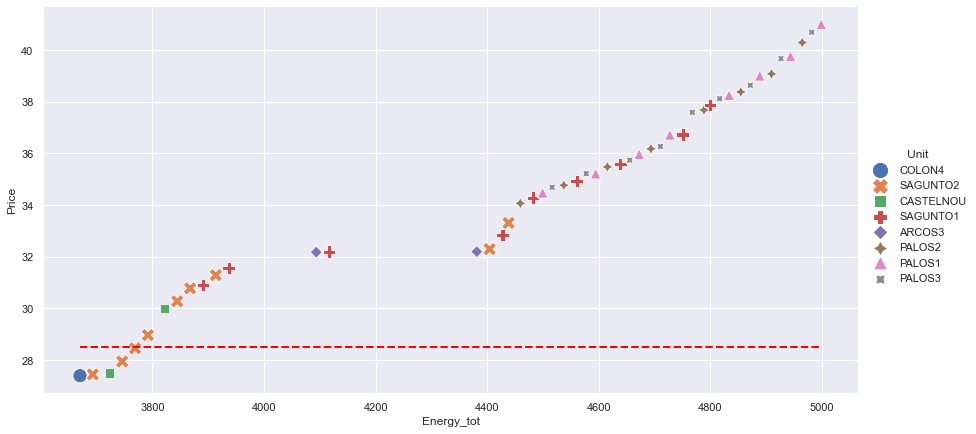

In [40]:
#Choosing the energy range considered
lim_min = 3600
lim_max = 5000

df_plot_all_sub = df_plot_all[(df_plot_all['Energy_tot'] > lim_min) &
                              (df_plot_all['Energy_tot'] < lim_max)]

sns.relplot(data=df_plot_all_sub, x='Energy_tot', y='Price', hue='Unit', height=6, aspect=2,
           style='Unit', size='Unit', sizes=(100, 200));

plt.plot(df_plot_all_sub['Energy_tot'], df_plot_all_sub['Marg_Price'], ls = '--', lw = 2, color = 'red');

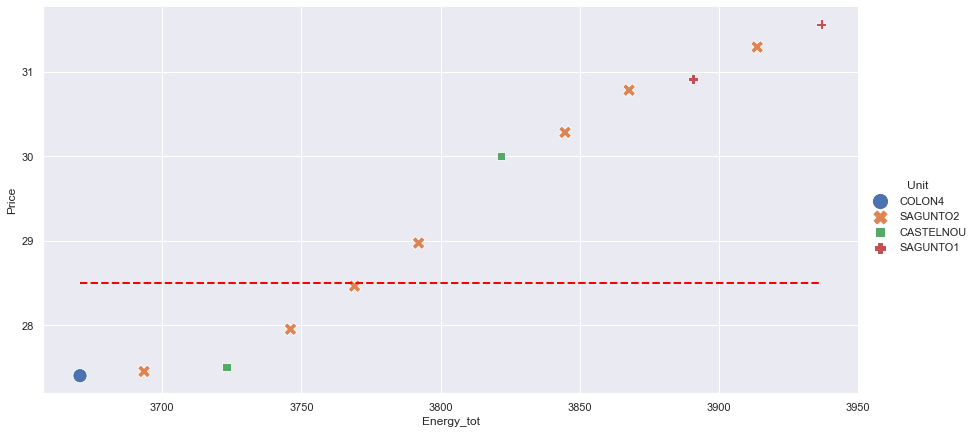

In [41]:
lim_min = 3600
lim_max = 4000

df_plot_all_sub = df_plot_all[(df_plot_all['Energy_tot'] > lim_min) &
                              (df_plot_all['Energy_tot'] < lim_max)]

sns.relplot(data=df_plot_all_sub, x='Energy_tot', y='Price', hue='Unit', height=6, aspect=2,
           style='Unit', size='Unit', sizes=(100, 200));

plt.plot(df_plot_all_sub['Energy_tot'], df_plot_all_sub['Marg_Price'], ls = '--', lw = 2, color = 'red');

Different plots divided by blocks.

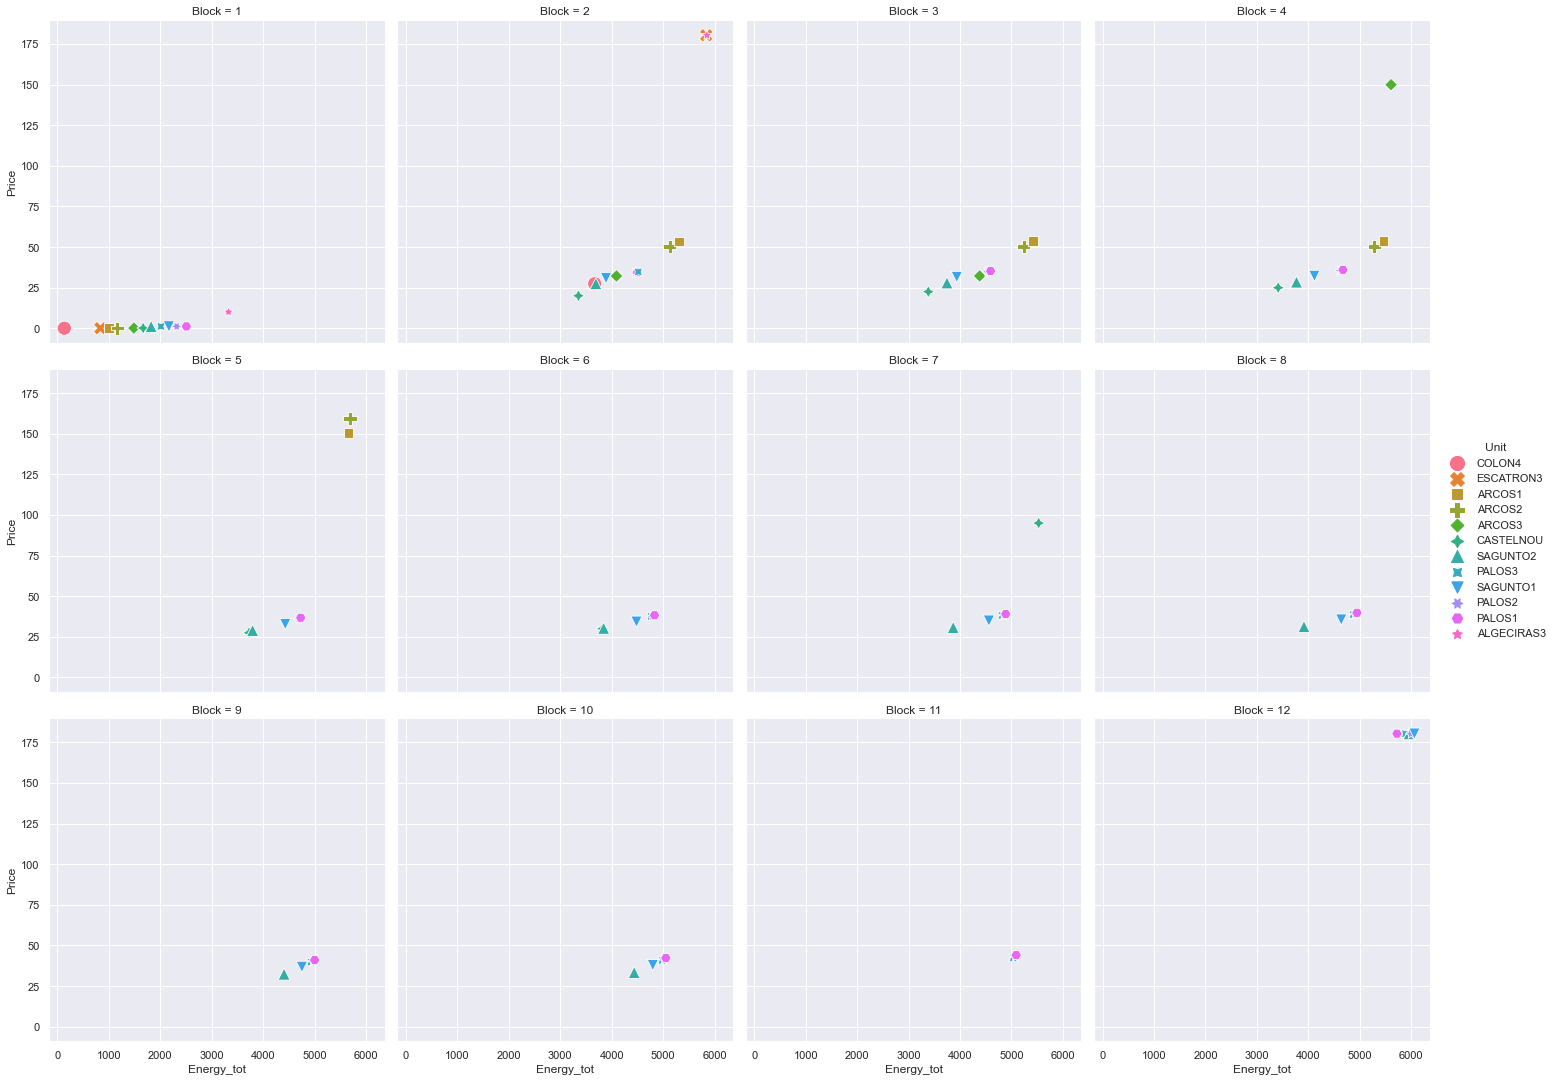

In [42]:
sns.relplot(data=df_plot_all, x='Energy_tot', y='Price', hue='Unit', col='Block', col_wrap=4,
           style='Unit', size='Unit', sizes=(100, 200));

Another way to plot the final aggregate curve.

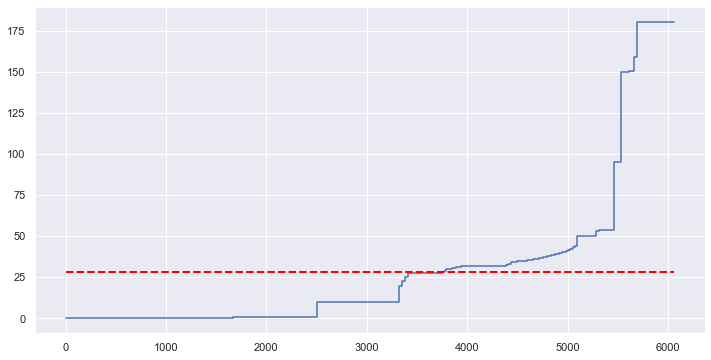

In [43]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-8-15'
hour = 18

df_plot_all = df_units[(df_units['Date']==date) &
         (df_units['Period']==hour)]

df_plot_all = df_plot_all.sort_values('Price')
df_plot_all.reset_index(drop=True, inplace=True)
df_plot_all['Energy_tot'] = df_plot_all['Energy'].cumsum()

plt.plot(pd.Series(0).append(df_plot_all['Energy_tot']), 
                    pd.Series(df_plot_all['Price'].iloc[0]).append(df_plot_all['Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)');

plt.plot(pd.Series(0).append(df_plot_all['Energy_tot']), 
                    pd.Series(df_plot_all['Marg_Price'].iloc[0]).append(df_plot_all['Marg_Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)', ls = '--', lw = 2, color = 'red');

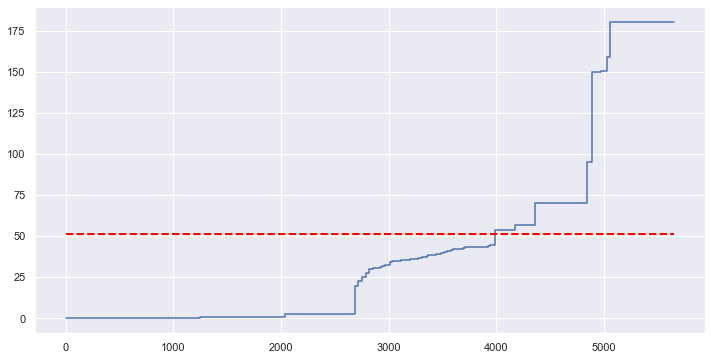

In [44]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-09-15'
hour = 24

df_plot_all = df_units[(df_units['Date']==date) & (df_units['Period']==hour)]

df_plot_all = df_plot_all.sort_values('Price')
df_plot_all.reset_index(drop=True, inplace=True)
df_plot_all['Energy_tot'] = df_plot_all['Energy'].cumsum()

plt.plot(pd.Series(0).append(df_plot_all['Energy_tot']), 
                    pd.Series(df_plot_all['Price'].iloc[0]).append(df_plot_all['Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)');

plt.plot(pd.Series(0).append(df_plot_all['Energy_tot']), 
                    pd.Series(df_plot_all['Marg_Price'].iloc[0]).append(df_plot_all['Marg_Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)', ls = '--', lw = 2, color = 'red');

#### CREATING NEW FEATURES

In this section, new features are included in the dataframe for a certain date and hour to check the revenues obtained for every unit and to ilustrate if the result of the load energy for every unit will be feasible. Note that combined cycles cannot operate below certain gas turbine loads due to emission restrictions.

First of all, only bids with bid price lower than the marginal price are considered. Then, the maximum block for every unit is chosen, since the maximum block is the cummulative block energy that this unit has sold in the auction. 

Then, a load limit feature is created, considering this limit 0.5 for combined cycles configurations 1x1 (one gas turbine and one steam turbine), and 0.25 for combined cycles configurations 2x1 (two gas turbines and one steam turbine).

"Area" feature is created to see the money (€) that every unit has made and "Marg_Area" is the surplus for every unit.

In [45]:
#Function used to create "Load_limit" feature

def load_limit(Pot_max):
    if Pot_max > 500:
        load_limit = 0.25
    else:
        load_limit = 0.5
    return load_limit

In [46]:
#Function for selectioning only bid prices lower than the marginal price

def df_units_selection(dataframe):
    dataframe['delta_Marg_Price'] = dataframe['Marg_Price'] - dataframe['Price']
    df_units_sel = dataframe[dataframe['delta_Marg_Price']>= 0]

    df_units_sel = df_units_sel.sort_values('Price')
    df_units_sel.reset_index(drop=True, inplace=True)

    #Selecting the maximum block and calculating the total energy sold by every unit
    df_units_sel = df_units_sel.merge(df_units_sel.groupby(['Unit','Date','Period'])[['Block']].max().reset_index(),how='inner')
    df_units_sel['Energy_tot_all'] = df_units_sel.groupby(['Date','Period'])['Energy_tot'].cumsum()

    #Creating a new feature to ilustrate the load of the unit at the energy block 
    df_units_sel['Energy_unit_ratio'] = df_units_sel['Energy_tot'] / df_units_sel['Pot_max']
    #Creating a load limit feature
    df_units_sel['Load_limit'] = df_units_sel['Pot_max'].apply(lambda x: load_limit(x))
    #Creating a load limit comparison
    df_units_sel['Load_limit_comp'] = df_units_sel['Energy_unit_ratio'] - df_units_sel['Load_limit']
    #Creating revenues features
    df_units_sel['Area'] = df_units_sel['Energy_tot'] * df_units_sel['Marg_Price']
    df_units_sel['Marg_Area'] = df_units_sel['Energy_tot'] * df_units_sel['delta_Marg_Price']

    return df_units_sel

In [47]:
df_units_sel = df_units_selection(df_units)

Now, it is possible to know the total amount of revenues for all the units.

In [48]:
#UNIT TOTAL REVENUES
df_units_sel.groupby('Unit')['Area'].sum().sort_values(ascending = False)

Unit
ESCATRON3    115,377,466.15
ALGECIRAS3    95,856,128.63
ARCOS3        84,707,989.58
COLON4        63,412,869.80
SAGUNTO2      60,914,812.74
PALOS3        58,364,830.79
PALOS1        58,028,686.18
SAGUNTO1      57,313,986.94
PALOS2        50,474,664.35
ARCOS1        38,625,370.59
ARCOS2        36,401,581.41
CASTELNOU     33,862,357.23
Name: Area, dtype: float64

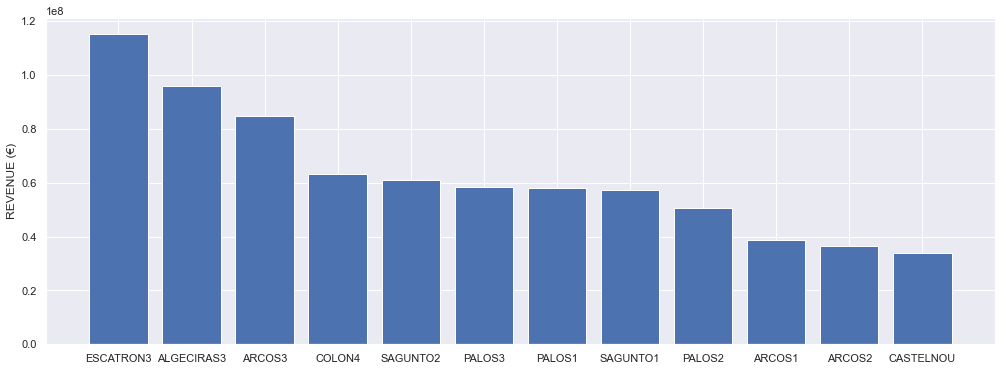

In [49]:
plt.figure().set_size_inches(17,6) 

ys = df_units_sel.groupby('Unit')['Area'].sum().sort_values(ascending = False).tolist()
labels = df_units_sel.groupby('Unit')['Area'].sum().sort_values(ascending = False).index.tolist()
xs = range(len(ys))
plt.bar(xs, ys);
plt.xticks(xs, labels);
plt.ylabel('REVENUE (€)');

In [50]:
#UNIT TOTAL REVENUES CONSIDERING LOAD LIMITATION
df_units_revenue = df_units_sel[df_units_sel['Load_limit_comp']>=0].groupby('Unit')['Area'].sum().sort_values(ascending=False)
df_units_revenue = df_units_revenue.reset_index()
df_units_revenue

,Unit,Area
0,ESCATRON3,"111,903,756.46"
1,ALGECIRAS3,"92,279,101.41"
2,ARCOS3,"69,480,574.39"
3,COLON4,"58,827,562.40"
4,SAGUNTO2,"50,207,470.20"
5,SAGUNTO1,"41,121,730.83"
6,PALOS3,"40,789,047.29"
7,PALOS1,"40,538,021.72"
8,PALOS2,"36,086,860.69"
9,CASTELNOU,"33,449,363.04"


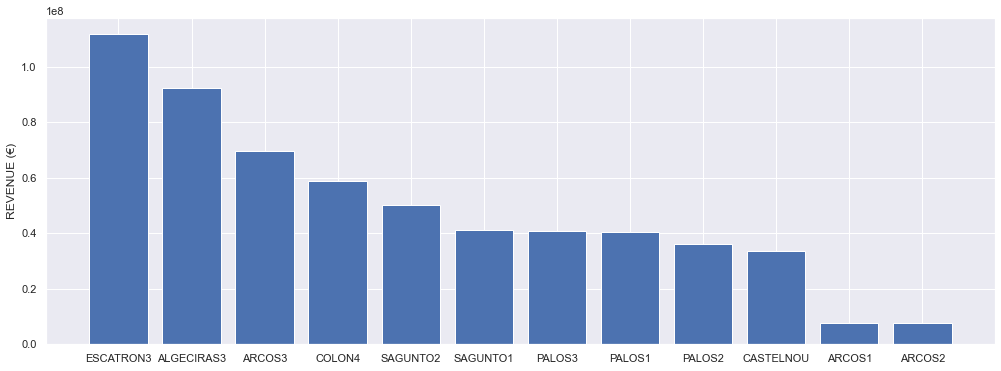

In [51]:
plt.figure().set_size_inches(17,6) 

ys = df_units_revenue.groupby('Unit')['Area'].sum().sort_values(ascending=False).tolist()
labels = df_units_revenue.groupby('Unit')['Area'].sum().sort_values(ascending = False).index.tolist()
xs = range(len(ys))
plt.bar(xs, ys);
plt.xticks(xs, labels);
plt.ylabel('REVENUE (€)');

In [52]:
#UNIT TOTAL ENERGY CONSIDERING LOAD LIMITATION
df_units_energy = pd.DataFrame(df_units_sel[df_units_sel['Load_limit_comp']>=0].groupby('Unit')['Energy'].sum().sort_values(ascending=False))
df_units_energy = df_units_energy.reset_index()
df_units_energy

,Unit,Energy
0,ESCATRON3,"2,797,720.20"
1,ALGECIRAS3,"2,382,034.20"
2,COLON4,"925,569.00"
3,ARCOS3,"660,525.30"
4,CASTELNOU,"124,213.50"
5,SAGUNTO2,"72,929.50"
6,SAGUNTO1,"57,349.00"
7,PALOS2,"55,736.80"
8,ARCOS2,"53,777.10"
9,PALOS1,"52,409.00"


In [53]:
df_units_potmax = pd.DataFrame(df_units_sel[df_units_sel['Load_limit_comp']>=0].groupby('Unit')['Pot_max'].mean().sort_values(ascending=False))
df_units_potmax = df_units_potmax.reset_index()
df_units_potmax

,Unit,Pot_max
0,ALGECIRAS3,830.10
1,ARCOS3,822.90
2,ESCATRON3,818.00
3,CASTELNOU,797.80
4,SAGUNTO2,419.60
5,SAGUNTO1,417.30
6,PALOS3,397.80
7,ARCOS1,395.60
8,PALOS2,395.60
9,PALOS1,394.10


In the following dataframe an estimation of the working hours is presented per each unit.

In [54]:
df_units_workinghours = df_units_energy.merge(df_units_potmax, how='inner')
df_units_workinghours['Working_hours'] = df_units_workinghours['Energy'] / df_units_workinghours['Pot_max']
df_units_workinghours

,Unit,Energy,Pot_max,Working_hours
0,ESCATRON3,"2,797,720.20",818.00,"3,420.20"
1,ALGECIRAS3,"2,382,034.20",830.10,"2,869.57"
2,COLON4,"925,569.00",392.00,"2,361.15"
3,ARCOS3,"660,525.30",822.90,802.68
4,CASTELNOU,"124,213.50",797.80,155.70
5,SAGUNTO2,"72,929.50",419.60,173.81
6,SAGUNTO1,"57,349.00",417.30,137.43
7,PALOS2,"55,736.80",395.60,140.89
8,ARCOS2,"53,777.10",379.40,141.74
9,PALOS1,"52,409.00",394.10,132.98


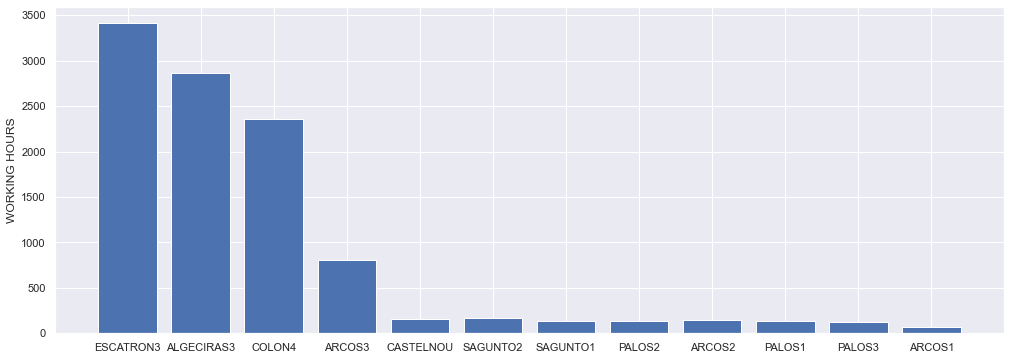

In [55]:
plt.figure().set_size_inches(17,6) 

ys = df_units_workinghours['Working_hours']
labels = df_units_workinghours['Unit'].unique()
xs = range(len(ys))
plt.bar(xs, ys);
plt.xticks(xs, labels);
plt.ylabel('WORKING HOURS');

In [56]:
df_units_total = df_units_revenue.merge(df_units_workinghours, how='inner')
df_units_total['Revenue/Pot_max'] = df_units_total['Area'] / df_units_total['Pot_max']
df_units_total

,Unit,Area,Energy,Pot_max,Working_hours,Revenue/Pot_max
0,ESCATRON3,"111,903,756.46","2,797,720.20",818.00,"3,420.20","136,801.66"
1,ALGECIRAS3,"92,279,101.41","2,382,034.20",830.10,"2,869.57","111,166.25"
2,ARCOS3,"69,480,574.39","660,525.30",822.90,802.68,"84,433.80"
3,COLON4,"58,827,562.40","925,569.00",392.00,"2,361.15","150,070.31"
4,SAGUNTO2,"50,207,470.20","72,929.50",419.60,173.81,"119,655.55"
5,SAGUNTO1,"41,121,730.83","57,349.00",417.30,137.43,"98,542.37"
6,PALOS3,"40,789,047.29","50,248.00",397.80,126.31,"102,536.57"
7,PALOS1,"40,538,021.72","52,409.00",394.10,132.98,"102,862.27"
8,PALOS2,"36,086,860.69","55,736.80",395.60,140.89,"91,220.58"
9,CASTELNOU,"33,449,363.04","124,213.50",797.80,155.70,"41,927.00"


In the following picture, the total revenue per installed power is presented. 

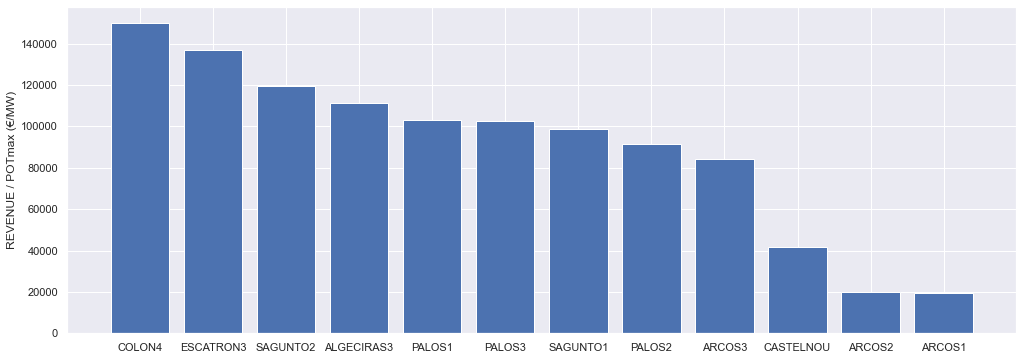

In [57]:
plt.figure().set_size_inches(17,6) 

ys = df_units_total['Revenue/Pot_max'].sort_values(ascending=False)
labels = df_units_total.loc[df_units_total['Revenue/Pot_max'].sort_values(ascending=False).index.tolist()]['Unit']
xs = range(len(ys))
plt.bar(xs, ys);
plt.xticks(xs, labels);
plt.ylabel('REVENUE / POTmax (€/MW)');

In [58]:
#UNIT TOTAL THEORETICAL SURPLUS
df_units_sel.groupby('Unit')['Marg_Area'].sum().sort_values(ascending=False)

Unit
ESCATRON3    102,406,030.99
ALGECIRAS3    78,282,280.09
ARCOS1        32,123,207.09
ARCOS3        31,485,126.30
ARCOS2        30,980,687.07
COLON4        21,589,933.33
PALOS3        19,119,710.40
PALOS1        18,621,214.73
SAGUNTO1      14,971,191.75
SAGUNTO2      13,770,473.44
PALOS2        12,815,760.99
CASTELNOU      8,686,023.82
Name: Marg_Area, dtype: float64

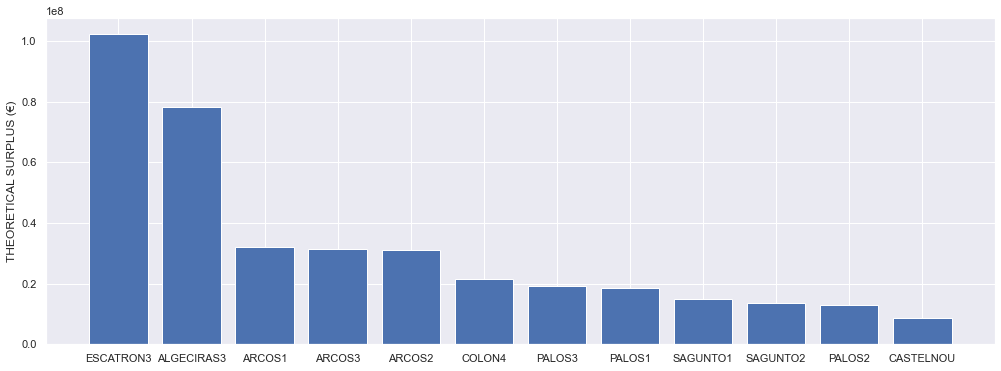

In [59]:
plt.figure().set_size_inches(17,6) 

ys = df_units_sel.groupby('Unit')['Marg_Area'].sum().sort_values(ascending=False).tolist()
labels = df_units_sel.groupby('Unit')['Marg_Area'].sum().sort_values(ascending=False).index.tolist()
xs = range(len(ys))
plt.bar(xs, ys);
plt.xticks(xs, labels);
plt.ylabel('THEORETICAL SURPLUS (€)');

In [60]:
#UNIT TOTAL THEORETICAL SURPLUS CONSIDERING LOAD LIMITATION
df_units_sel[df_units_sel['Load_limit_comp']>=0].groupby('Unit')['Marg_Area'].sum().sort_values(ascending=False)

Unit
ESCATRON3    98,933,887.77
ALGECIRAS3   74,767,793.55
COLON4       17,300,058.43
ARCOS3       16,450,194.55
CASTELNOU     8,274,741.23
SAGUNTO2      5,417,125.98
SAGUNTO1      2,869,852.58
PALOS3        2,294,399.45
ARCOS2        2,267,773.89
PALOS2        2,016,169.47
PALOS1        1,880,701.90
ARCOS1        1,239,750.00
Name: Marg_Area, dtype: float64

From the information above, it can be said that the REPSOL units sold more energy than the rest.

Plotting the bids considering only the bids lower that the marginal price for the period considered.

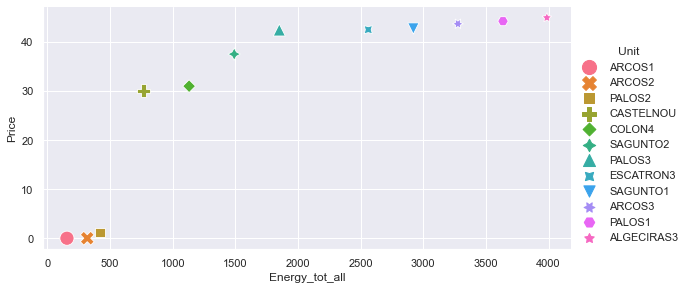

In [61]:
#Choosing a date and an hour
date = '2020-09-15'
hour = 24

df_units_sel_plot = df_units_sel[(df_units_sel['Date']==date) & (df_units_sel['Period']==hour)]
sns.relplot(data=df_units_sel_plot, x='Energy_tot_all', y='Price', hue='Unit', height=4, aspect=2,
           style='Unit', size='Unit', sizes=(100, 200));

In the next plot, the marginal area (revenue in €) for each unit is presented.

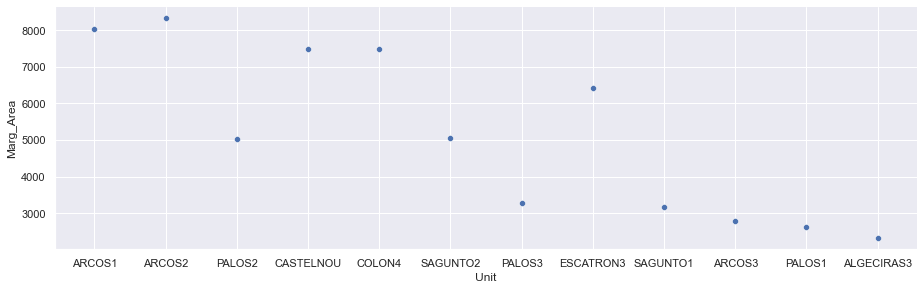

In [62]:
#Choosing a date and an hour

date = '2020-09-15'
hour = 24

df_units_sel_plot = df_units_sel[(df_units_sel['Date']==date) & (df_units_sel['Period']==hour)]
sns.relplot(data=df_units_sel_plot, x='Unit', y='Marg_Area', height=4, aspect=3.2);

Plotting the bids considering only the bids lower that the marginal price, and with loads higher than the load limit for the period considered.

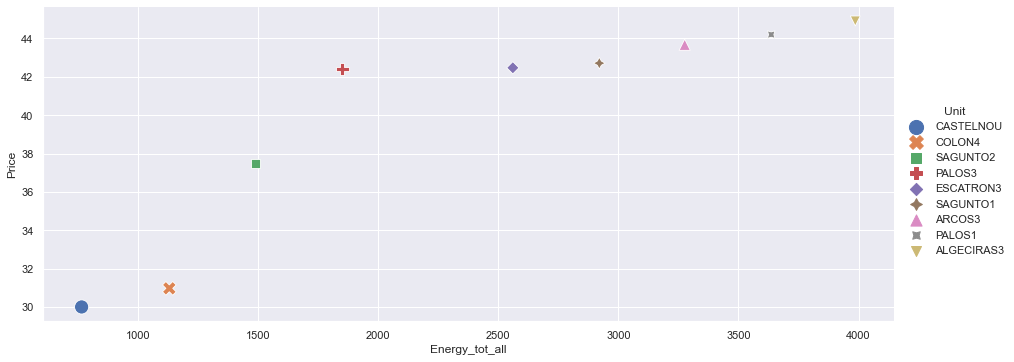

In [63]:
#Choosing a date and an hour
date = '2020-09-15'
hour = 24

df_units_sel_plot = df_units_sel[(df_units_sel['Date']==date) & (df_units_sel['Period']==hour)]

sns.relplot(data=df_units_sel_plot[df_units_sel_plot['Energy_unit_ratio']>=df_units_sel_plot['Load_limit']],
            x='Energy_tot_all', y='Price', hue='Unit', height=5, aspect=2.5,
            style='Unit', size='Unit', sizes=(100, 200));

### HYDRAULIC PLANTS

Just several bid curves to see the differences in bids for certain dates and hours.

NO DATA IN DATAFRAME FOR THAT CHOICE


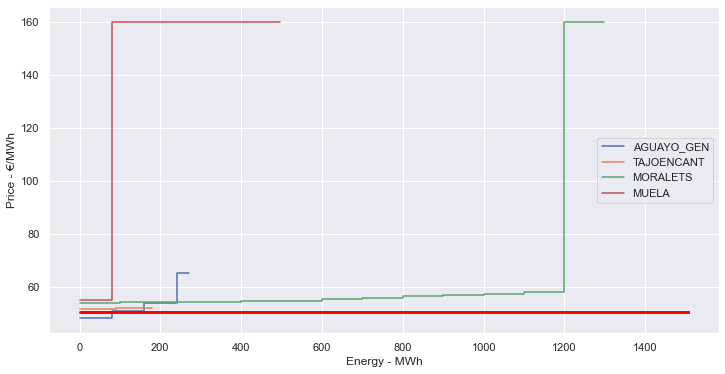

In [64]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-9-15'
hour = 18

for unit in unit_hyd_list:
    plot_bid_curve(df_units_hyd[df_units_hyd['Unit']==unit], date, hour)
    plt.legend(df_units_hyd['Unit'].unique())

df_plot = df_units_hyd[(df_units_hyd['Date'] == date) & (df_units_hyd['Period'] == hour)]
plt.plot(pd.Series(0).append(df_plot['Pot_max']), 
                    pd.Series(df_plot['Marg_Price'].iloc[0]).append(df_plot['Marg_Price']), 
                    drawstyle = 'steps', 
                    label = 'steps (=steps-pre)',
                    lw = 3,
                    color = 'red');

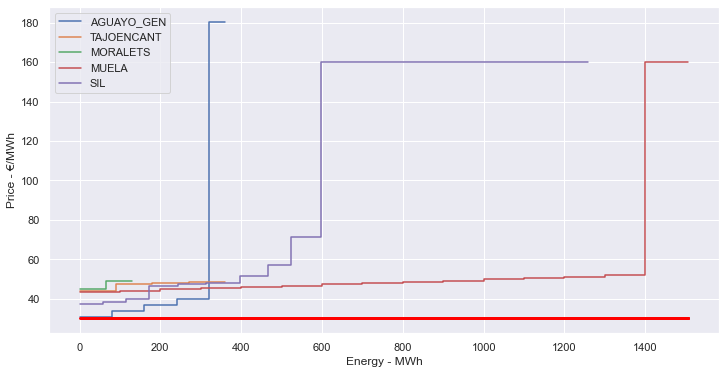

In [65]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-2-15'
hour = 18

for unit in unit_hyd_list:
    plot_bid_curve(df_units_hyd[df_units_hyd['Unit']==unit], date, hour)
    plt.legend(df_units_hyd['Unit'].unique())

df_plot = df_units_hyd[(df_units_hyd['Date'] == date) & (df_units_hyd['Period'] == hour)]
plt.plot(pd.Series(0).append(df_plot['Pot_max']), 
                    pd.Series(df_plot['Marg_Price'].iloc[0]).append(df_plot['Marg_Price']), 
                    drawstyle = 'steps', 
                    label = 'steps (=steps-pre)',
                    lw = 3,
                    color = 'red');

#### CREATING A DATAFRAME WITH ALL THE BLOCKS OF ALL THE UNITS SORTED BY ASCENDING PRICE

In this section, the auction methodology of sorting the bids by block price is presented as an example of how the marginal price is defined.

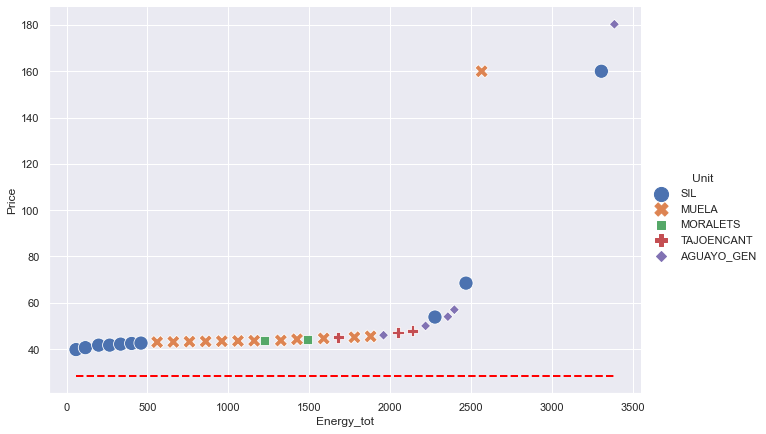

In [66]:
#Choosing a date and an hour
date = '2020-8-15'
hour = 18

df_plot_all_hyd = df_units_hyd[(df_units_hyd['Date']==date) & (df_units_hyd['Period']==hour)]

df_plot_all_hyd = df_plot_all_hyd.sort_values('Price')
df_plot_all_hyd.reset_index(drop=True, inplace=True)

#Creating the variable cumulative sum of block energy to plot the curve
df_plot_all_hyd['Energy_tot'] = df_plot_all_hyd['Energy'].cumsum()

sns.relplot(data=df_plot_all_hyd, x='Energy_tot', y='Price', hue='Unit', height=6, aspect=1.5,
           style='Unit', size='Unit', sizes=(100, 200))

plt.plot(df_plot_all_hyd['Energy_tot'], df_plot_all_hyd['Marg_Price'], ls = '--', lw = 2, color = 'red');

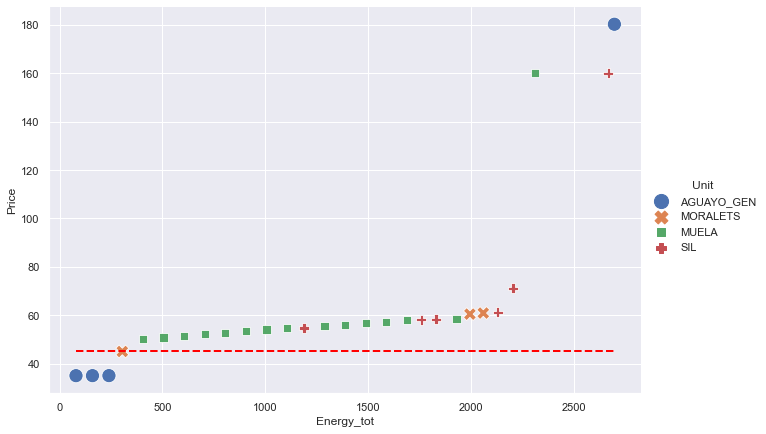

In [67]:
#Choosing a date and an hour
date = '2020-1-15'
hour = 18

df_plot_all_hyd = df_units_hyd[(df_units_hyd['Date']==date) & (df_units_hyd['Period']==hour)]

df_plot_all_hyd = df_plot_all_hyd.sort_values('Price')
df_plot_all_hyd.reset_index(drop=True, inplace=True)

#Creating the variable cumulative sum of block energy to plot the curve
df_plot_all_hyd['Energy_tot'] = df_plot_all_hyd['Energy'].cumsum()

sns.relplot(data=df_plot_all_hyd, x='Energy_tot', y='Price', hue='Unit', height=6, aspect=1.5,
           style='Unit', size='Unit', sizes=(100, 200))

plt.plot(df_plot_all_hyd['Energy_tot'], df_plot_all_hyd['Marg_Price'], ls = '--', lw = 2, color = 'red');

In this plot, all the prices are higher that the marginl price, so none of the units sold electricity during that period.


In the following plot, bid prices for each unit are plotted in a line.

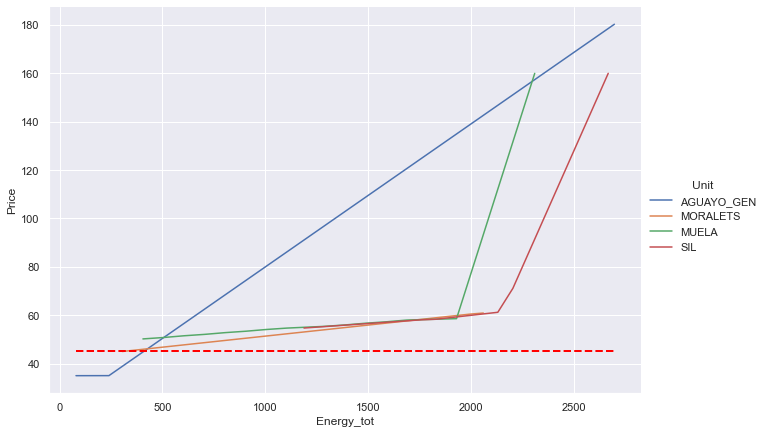

In [68]:
sns.relplot(data=df_plot_all_hyd, x='Energy_tot', y='Price', hue='Unit', kind = 'line', height=6, aspect=1.5)

plt.plot(df_plot_all_hyd['Energy_tot'], df_plot_all_hyd['Marg_Price'], ls = '--', lw = 2, color = 'red');

Same example for other date and hour.

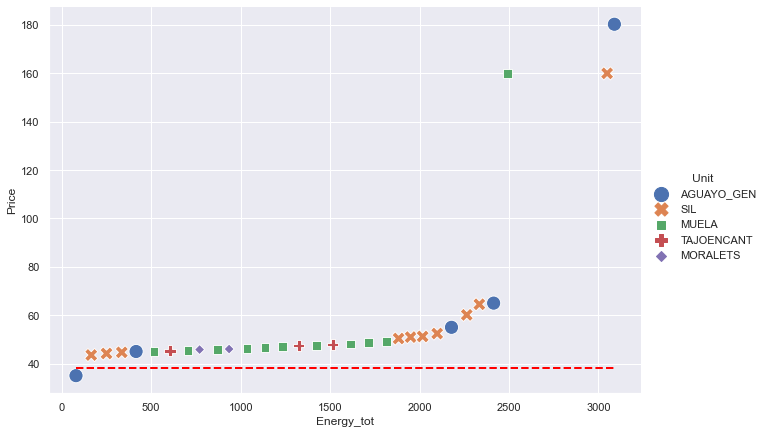

In [69]:
#Choosing a date and an hour
date = '2020-10-31'
hour = 18

df_plot_all_hyd = df_units_hyd[(df_units_hyd['Date']==date) & (df_units_hyd['Period']==hour)]

df_plot_all_hyd = df_plot_all_hyd.sort_values('Price')
df_plot_all_hyd.reset_index(drop=True, inplace=True)

#Creating the variable cumulative sum of block energy to plot the curve
df_plot_all_hyd['Energy_tot'] = df_plot_all_hyd['Energy'].cumsum()

sns.relplot(data=df_plot_all_hyd, x='Energy_tot', y='Price', hue='Unit', height=6, aspect=1.5,
           style='Unit', size='Unit', sizes=(100, 200))

plt.plot(df_plot_all_hyd['Energy_tot'], df_plot_all_hyd['Marg_Price'], ls = '--', lw = 2, color = 'red');

Another way to plot the final cummulative curve.

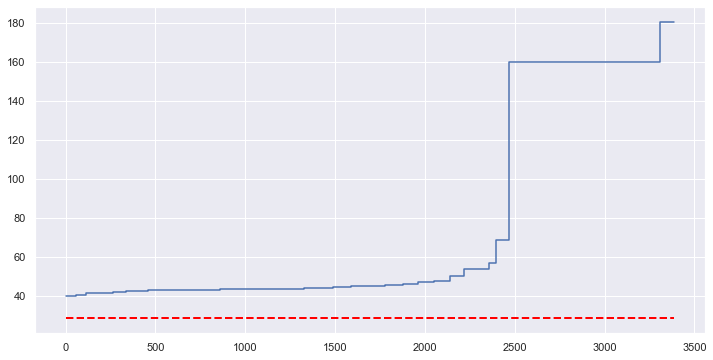

In [70]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-8-15'
hour = 18

df_plot_all_hyd = df_units_hyd[(df_units_hyd['Date']==date) & (df_units_hyd['Period']==hour)]

df_plot_all_hyd = df_plot_all_hyd.sort_values('Price')
df_plot_all_hyd.reset_index(drop=True, inplace=True)
df_plot_all_hyd['Energy_tot'] = df_plot_all_hyd['Energy'].cumsum()

plt.plot(pd.Series(0).append(df_plot_all_hyd['Energy_tot']), 
                    pd.Series(df_plot_all_hyd['Price'].iloc[0]).append(df_plot_all_hyd['Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)');

plt.plot(pd.Series(0).append(df_plot_all_hyd['Energy_tot']), 
                    pd.Series(df_plot_all_hyd['Marg_Price'].iloc[0]).append(df_plot_all_hyd['Marg_Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)', ls = '--', lw = 2, color = 'red');

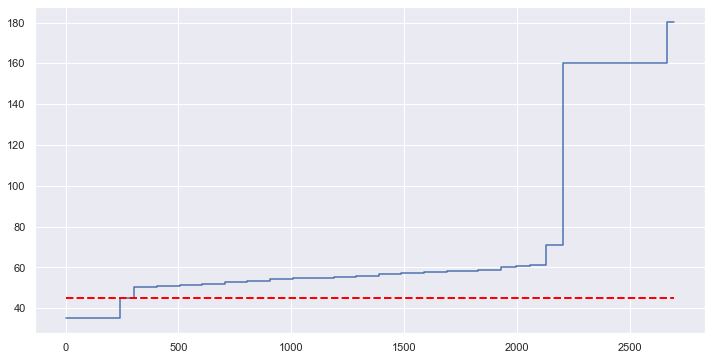

In [71]:
plt.figure().set_size_inches(12,6) 

#Choosing a date and an hour
date = '2020-1-15'
hour = 18

df_plot_all_hyd = df_units_hyd[(df_units_hyd['Date']==date) & (df_units_hyd['Period']==hour)]

df_plot_all_hyd = df_plot_all_hyd.sort_values('Price')
df_plot_all_hyd.reset_index(drop=True, inplace=True)
df_plot_all_hyd['Energy_tot'] = df_plot_all_hyd['Energy'].cumsum()

plt.plot(pd.Series(0).append(df_plot_all_hyd['Energy_tot']), 
                    pd.Series(df_plot_all_hyd['Price'].iloc[0]).append(df_plot_all_hyd['Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)');

plt.plot(pd.Series(0).append(df_plot_all_hyd['Energy_tot']), 
                    pd.Series(df_plot_all_hyd['Marg_Price'].iloc[0]).append(df_plot_all_hyd['Marg_Price']), 
                    drawstyle='steps', 
                    label='steps (=steps-pre)', ls = '--', lw = 2, color = 'red');

#### CREATING NEW FEATURES

In this section, new features are included in the dataframe in order to check the revenues obtained for every unit.

First of all, only bids with bid price lower than the marginal price are considered. Then, the maximum block for every unit is chosen, since the maximum block is the cummulative block energy that this unit has sold in the auction. 

Besides this, "Area" feature is created to see the money (€) that every unit has made and "Marg_Area" is the surplus for every unit.

In [72]:
#Function for selecting only bid prices lower than the marginal price

def df_units_hyd_selection(dataframe):
    dataframe['delta_Marg_Price'] = dataframe['Marg_Price'] - dataframe['Price']
    df_units_sel = dataframe[dataframe['delta_Marg_Price']>= 0]

    df_units_sel = df_units_sel.sort_values('Price')
    df_units_sel.reset_index(drop=True, inplace=True)

    #Selecting the maximum block and calculating the total energy sold by every unit
    df_units_sel = df_units_sel.merge(df_units_sel.groupby(['Unit','Date','Period'])[['Block']].max().reset_index(),how='inner')
    df_units_sel['Energy_tot_all'] = df_units_sel.groupby(['Date','Period'])['Energy_tot'].cumsum()

    #Creating revenues features
    df_units_sel['Area'] = df_units_sel['Energy_tot'] * df_units_sel['Marg_Price']
    df_units_sel['Marg_Area'] = df_units_sel['Energy_tot'] * df_units_sel['delta_Marg_Price']

    return df_units_sel

In [73]:
df_units_hyd_sel = df_units_hyd_selection(df_units_hyd)

Now, it is possible to now the total amount of revenues for all the units.

In [74]:
#UNIT TOTAL REVENUES
df_units_hyd_sel.groupby('Unit')['Area'].sum().sort_values(ascending = False)

Unit
MUELA        22,399,379.00
AGUAYO_GEN   21,319,900.80
SIL          19,651,066.14
MORALETS      9,685,110.80
TAJOENCANT    5,178,172.50
Name: Area, dtype: float64

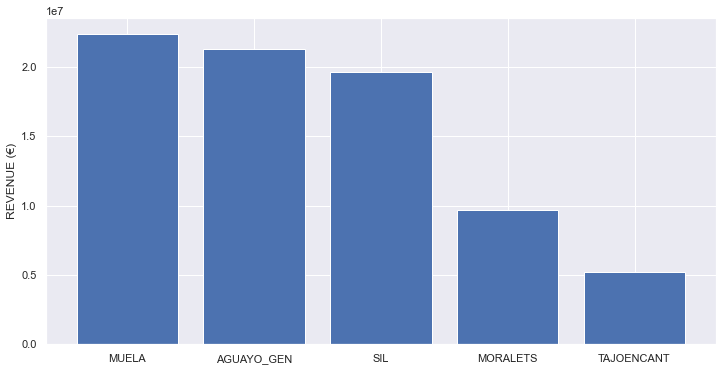

In [75]:
plt.figure().set_size_inches(12,6) 

ys = df_units_hyd_sel.groupby('Unit')['Area'].sum().sort_values(ascending=False).tolist()
labels = df_units_hyd_sel.groupby('Unit')['Area'].sum().sort_values(ascending=False).index.tolist()
xs = range(len(ys))
plt.bar(xs, ys);
plt.xticks(xs, labels);
plt.ylabel('REVENUE (€)');

In [76]:
#UNIT TOTAL THEORETICAL SURPLUS
df_units_hyd_sel.groupby('Unit')['Marg_Area'].sum().sort_values(ascending=False)

Unit
SIL          12,351,015.14
AGUAYO_GEN    1,933,525.60
MORALETS        828,469.70
MUELA           364,322.00
TAJOENCANT      285,466.50
Name: Marg_Area, dtype: float64

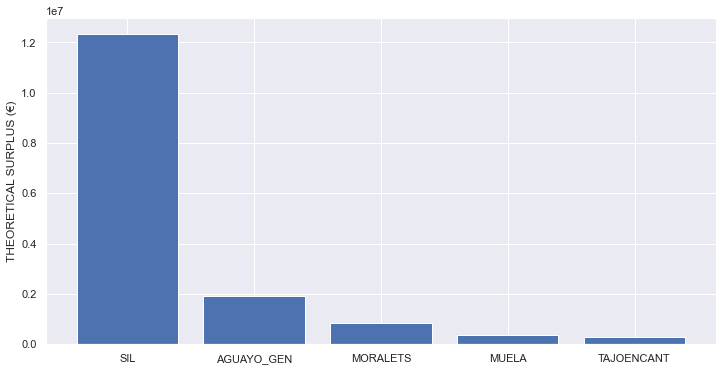

In [77]:
plt.figure().set_size_inches(12,6) 

ys = df_units_hyd_sel.groupby('Unit')['Marg_Area'].sum().sort_values(ascending=False).tolist()
labels = df_units_hyd_sel.groupby('Unit')['Marg_Area'].sum().sort_values(ascending=False).index.tolist()
xs = range(len(ys))
plt.bar(xs, ys);
plt.xticks(xs, labels);
plt.ylabel('THEORETICAL SURPLUS (€)');

The differences between the theoretical surplus and the real revenue depends on the bid price of the offers. It is clear from the above, that SIL unit always offer at lower price than the rest, in theory because its opportunity cost is lower.